In [1]:
%matplotlib inline

In [2]:
__import__("os").environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

[BaseModel without forward](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/model.py#L238)

[Model without forward](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/model.py)

[(Base) Model with forward](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/nn/tasks.py)

In [3]:
import os
import copy
import matplotlib.pyplot as plt

import torch
import random
import numpy as np

seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


Actaully start in [engine.model._new](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/model.py#L238) but we can just go straight to [`DetectionModel`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/nn/tasks.py) because what done prior to call to create `DetectionModel` was just load `.yaml` and check `task` and model size.

In [4]:
import sys
sys.path.append('../../..')

%load_ext autoreload
%autoreload 2

from computer_vision.yolov11.data.utils import imread
from computer_vision.yolov11.modules.detector import DetectionModel
from computer_vision.yolov11.data.augment import LetterBox # for preprocessing
from computer_vision.yolov11.utils.nms import non_max_suppression # for post processing
from computer_vision.yolov11.utils.ops import scale_boxes # for post processing, i.e, scaling boxes back to original image size

### Load model and set the names of clases

In [5]:
model_dirpath='D:/results/yolov11/checkpoints'
# to load ultralytics models (models downloaded previously by ultralytics) we need to use ultralytics library, as a work around,
# we resave it using torch to remove ultralytics dependency
# checkpoint=torch.load(os.path.join(model_dirpath, 'yolo11n.pt'), map_location=torch.device('cpu'), weights_only=False)

model=DetectionModel(cfg='../yolo11.yaml', ch=3)
checkpoint=torch.load(os.path.join(model_dirpath, 'predictor_yolo11n_torch.pt'), map_location=torch.device('cpu'), weights_only=True) # may have model. as added prefix
try:
    model.load_state_dict(checkpoint['model'])
except RuntimeError as err:
    state_dict=copy.deepcopy(model.state_dict())
    for name, params in checkpoint['model'].items():
        name=name[len('model.'):] # each parameter name is model.model.xxx so we need to remove 1 model.
        
        if name not in state_dict or params.shape!=state_dict[name].shape:
            print(name, name in state_dict, params.shape!=state_dict[name].shape if name in state_dict else None)
        else: state_dict[name]=params
    model.load_state_dict(state_dict)

# class names
model.names={0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
print('number of classes: ', len(model.names))

In BaseModel._predict_once max_idx -1 embed {-1}
number of classes:  80


### Load sample test data

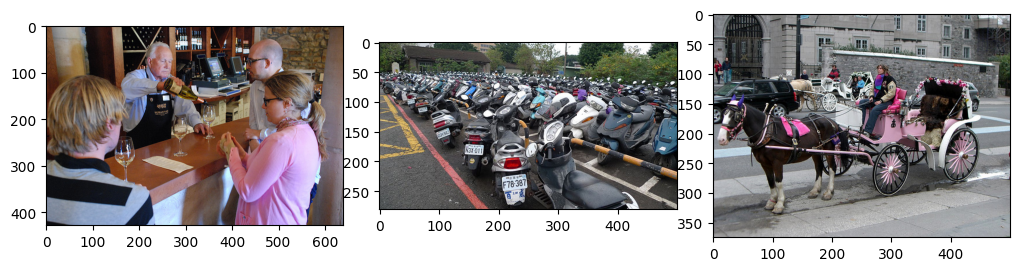

In [6]:
data_dirpath='D:/data/coco/coco/images/test2017'
image_files=['000000000069.jpg', '000000000774.jpg', '000000502391.jpg']
images=[imread(os.path.join(data_dirpath, file)) for file in image_files]
_, ax=plt.subplots(1,3,figsize=(10,3))
for i, im in enumerate(images): ax[i].imshow(im[...,::-1]) # BGR to RGB
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

### Preprocess images

[`pre_transform`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/predictor.py#L152) called inside [`preprocess`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/predictor.py#L152) which, in turn, called by `self.preprocess(im0s)` in [`stream_inference`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/predictor.py)

imgs_  [(640, 640, 3), (640, 640, 3), (640, 640, 3)]
imgs  torch.Size([3, 3, 640, 640])


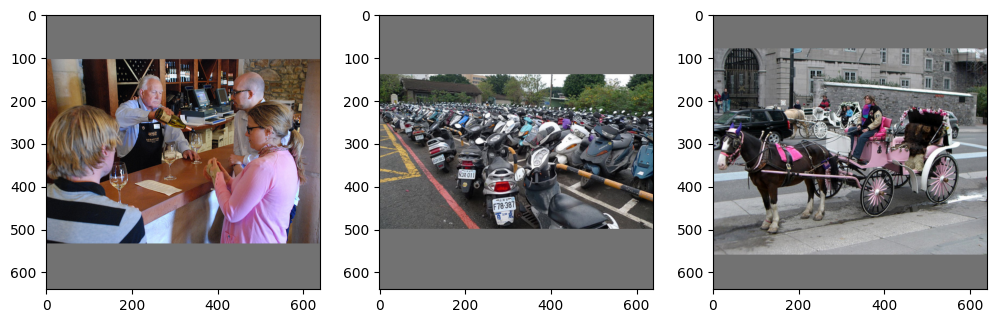

In [7]:
# fit images into desired input training size
same_shape=len({x.shape for x in images})==1
letterbox=LetterBox((640,640), auto=same_shape, stride=(8,16,32)) # stride is model strides
imgs_=[letterbox(image=x) for x in images]
print('imgs_ ', [i.shape for i in imgs_])

# let's look at the image
_, ax=plt.subplots(1,3,figsize=(10,3))
for i, im in enumerate(imgs_): ax[i].imshow(im[...,::-1]) # BGR to RGB
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

# stack them to form batched image and normalized them
imgs=np.stack(imgs_) # BGR
imgs=imgs[...,::-1] # BGR to RGB
imgs=np.ascontiguousarray( imgs.transpose((0,3,1,2)) ) # BxHxWxC to BxCxHxW
imgs=torch.from_numpy(imgs)/255. # from 0-255 to 0-1
print('imgs ', imgs.shape)

### Run inference

In [8]:
# Ultralytics predictions having shape (batch_size, num_classes + 4 + num_masks, num_boxes) containing boxes, classes, and optional masks.
# In this case, the first output is tensor of size batch_size, num_classes + 4, num_boxes
model.eval()
with torch.no_grad(): preds=model(imgs)
print('preds ', type(preds), len(preds), [type(p) for p in preds], [p.shape if isinstance(p, torch.Tensor) else len(p) for p in preds])

In BaseModel._predict_once max_idx -1 embed {-1}
In modules.head._inference self.dynamic False| self.shape None | shape torch.Size([3, 144, 80, 80])
In modules.head._inference x [torch.Size([3, 144, 80, 80]), torch.Size([3, 144, 40, 40]), torch.Size([3, 144, 20, 20])] |  self.stride tensor([ 8., 16., 32.])
preds  <class 'tuple'> 2 [<class 'torch.Tensor'>, <class 'list'>] [torch.Size([3, 84, 8400]), 3]


### Postprocessing

[`ultralytics.models.yolo.detect.predict.DetectionPredictor.postprocess`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/predict.py) which internally called `ultralytics.models.yolo.detect.predict.DetectionPredictor.construct_results` and `ultralytics.models.yolo.detect.predict.DetectionPredictor.construct_result`

In [9]:
# Each output is a tensor or numpy array with detection boxes of shape (num_boxes, 6) or (num_boxes, 7). Columns should contain
# [x1, y1, x2, y2, (optional) track_id, confidence, class].
pred_outs=non_max_suppression(preds, conf_thres=0.25, iou_thres=0.7, classes=None, agnostic=False, multi_label=False, max_det=300, nc=0,
                        max_nms=30000, max_wh=7680, end2end= False, return_idxs= False)
print('pred_outs ', [p.shape for p in pred_outs])

pred_outs  [torch.Size([10, 6]), torch.Size([8, 6]), torch.Size([11, 6])]


##### Visualize outputs on network-input images 

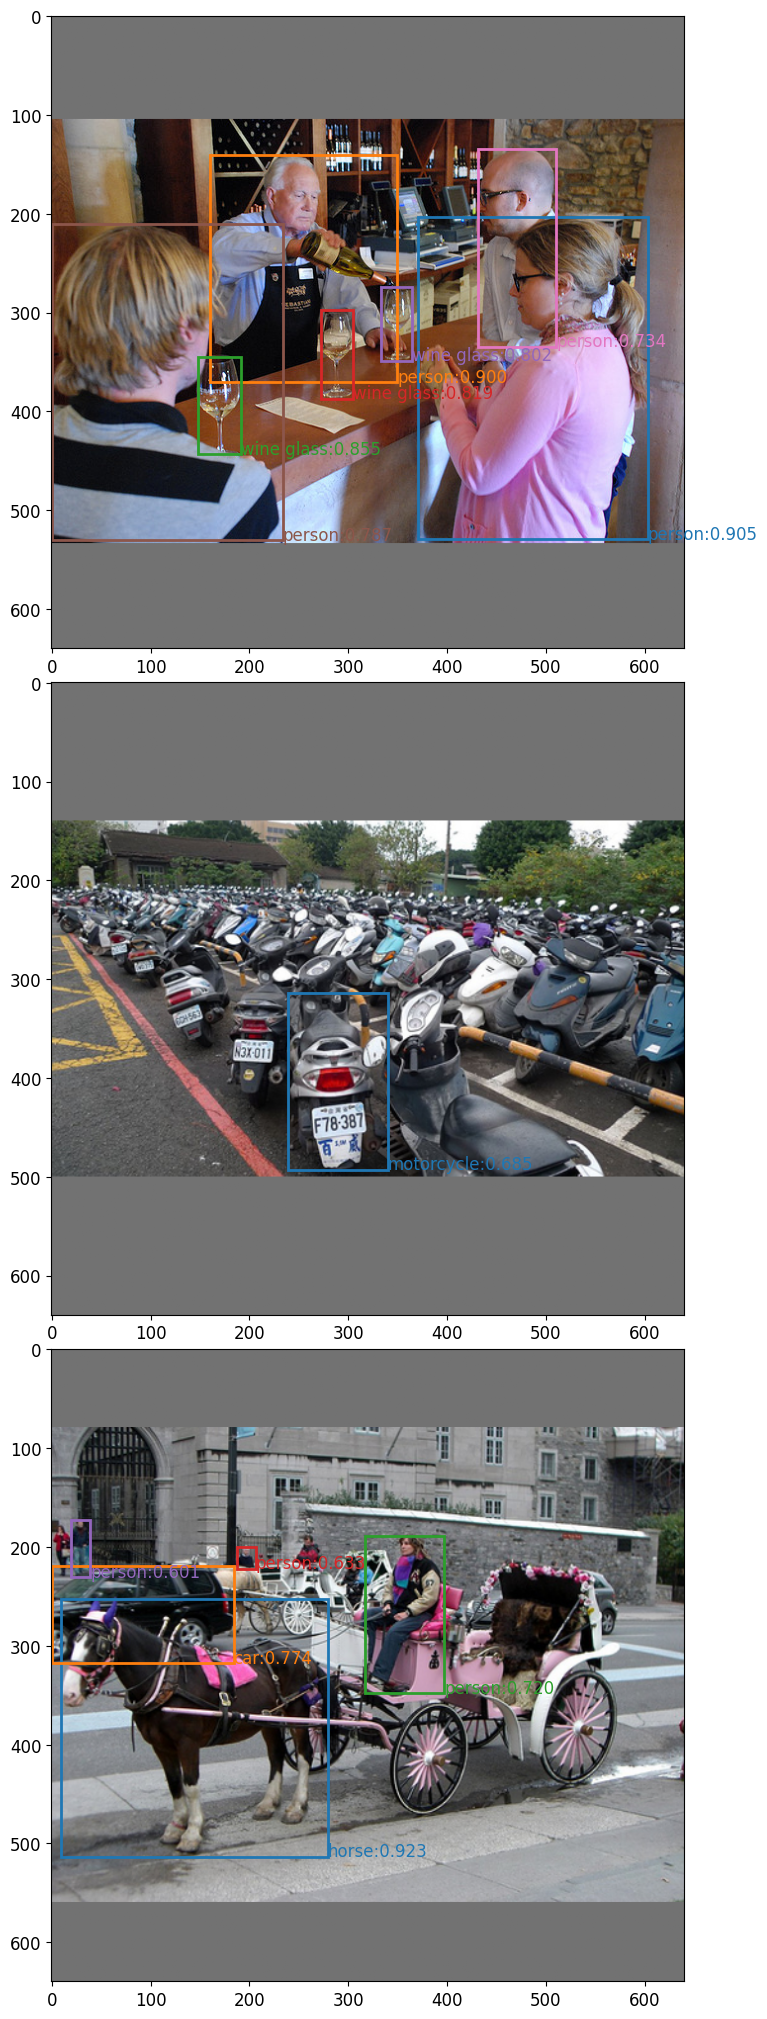

In [10]:
from matplotlib import patches
cmap = plt.get_cmap('tab10', 10)
plt.rcParams.update({'font.size'   : 12})

_, ax=plt.subplots(3,1,figsize=(20,20))

for i, (im, out) in enumerate(zip(imgs, pred_outs)):

    boxes=out[:,:4]
    confidence=out[:,-2]
    classes=[model.names[int(c)] for c in out[:,-1].tolist()]
    ax[i].imshow(im.permute(1,2,0)) # CxHxW to HxWxC
    for j, (box, conf, cls) in enumerate(zip(boxes, confidence, classes)):
        if conf < 0.6: continue # only pick confidence > 0.6
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[2:], f'{cls}:{conf.item():.3f}', color=cmap(j), fontsize=12)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

##### Visualize outputs on original images 

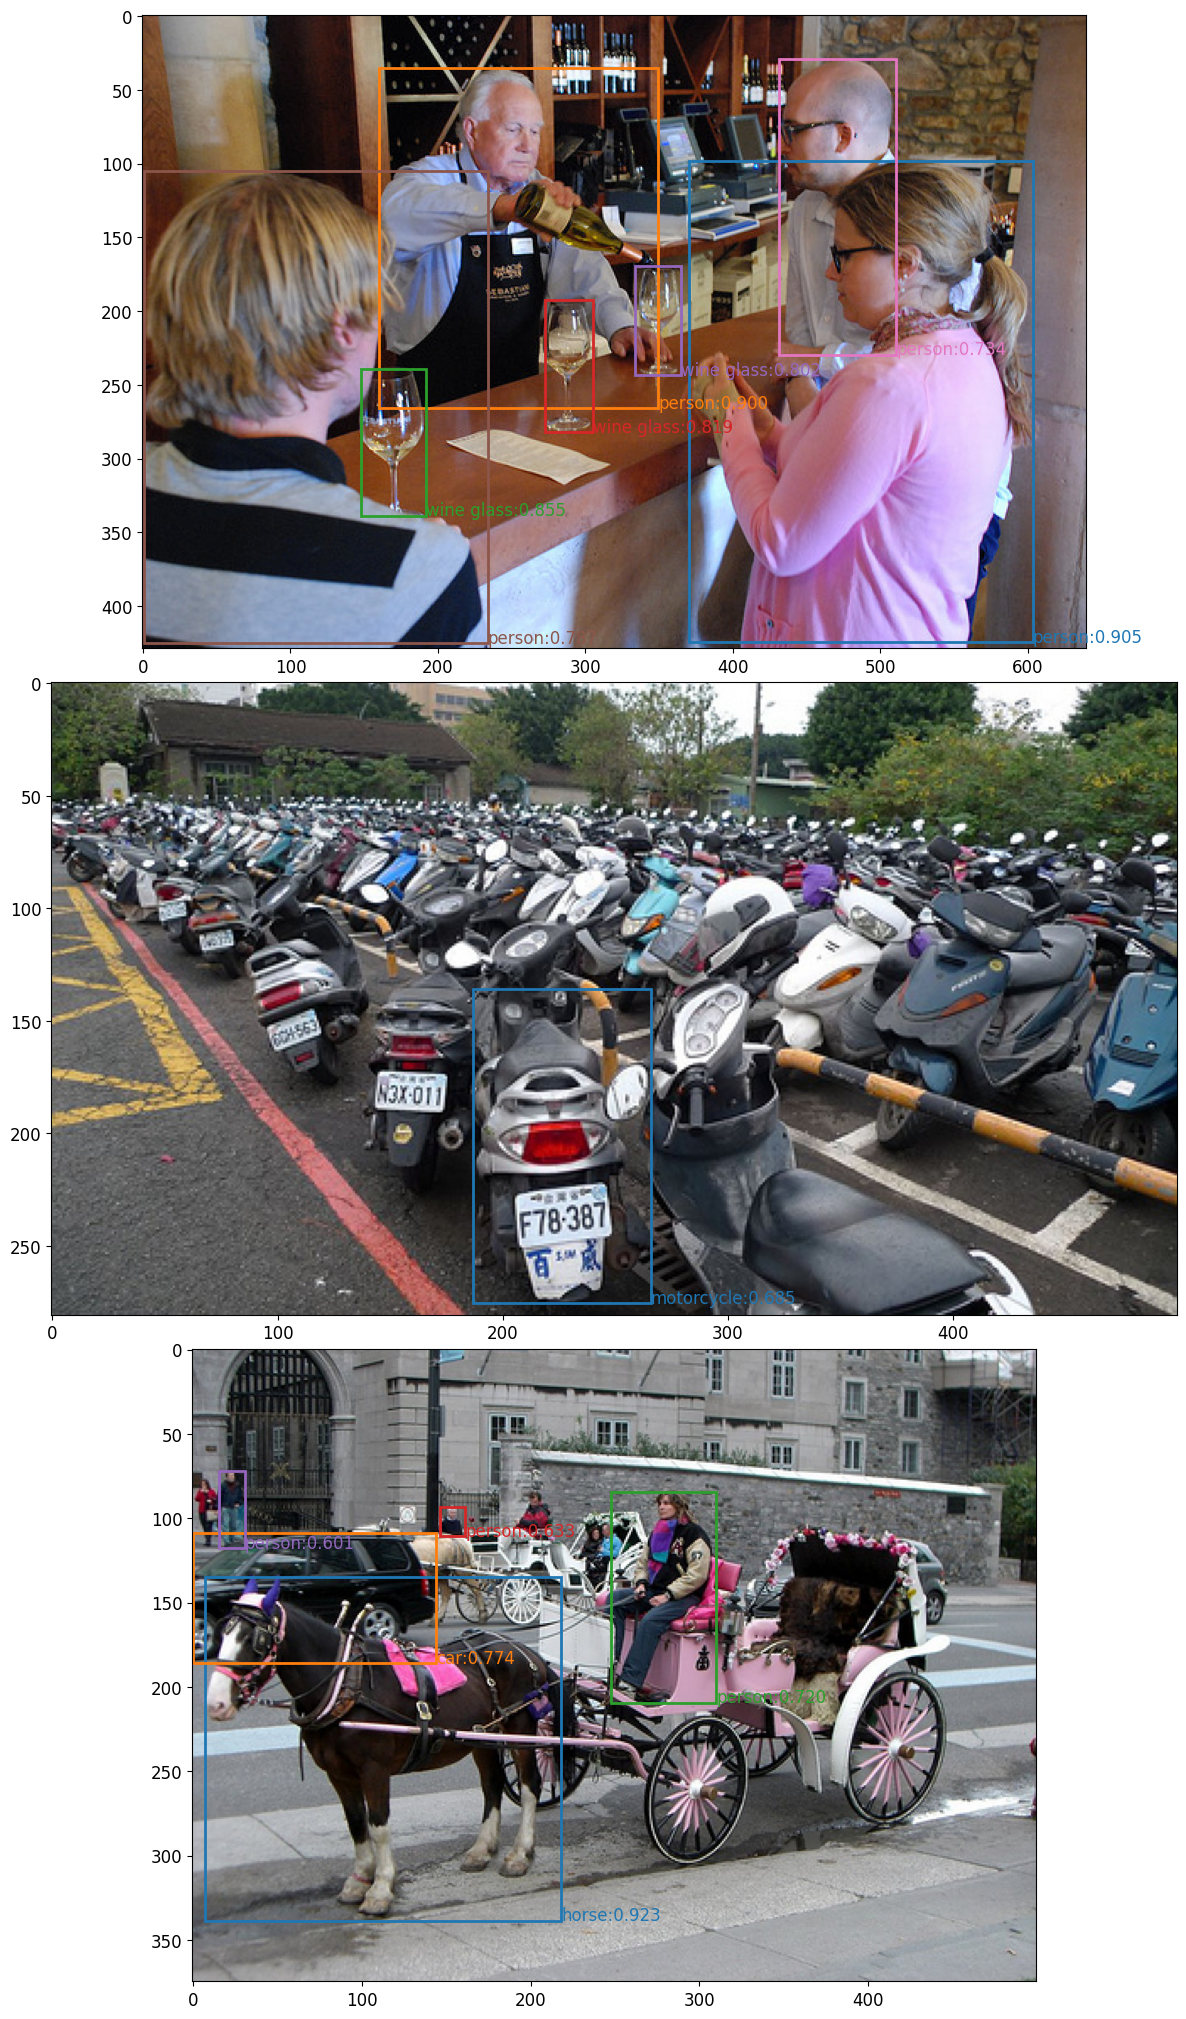

In [11]:
# adjust to old image

_, ax=plt.subplots(3,1,figsize=(20,20))
boxes_collection=dict()
for i, (im, out) in enumerate(zip(images, pred_outs)):

    boxes=scale_boxes(img1_shape=imgs.shape[-2:], boxes=out[:,:4], img0_shape=im.shape[:2], 
                          ratio_pad=None, padding=True, xywh=False)
    confidence=out[:,-2]
    classes=[model.names[int(c)] for c in out[:,-1].tolist()]
    ax[i].imshow(im[...,::-1]) # BGR to RGB 
    for j, (box, conf, cls) in enumerate(zip(boxes, confidence, classes)):
        if conf < 0.6: continue # only pick confidence > 0.6
        # Create a Rectangle patch
        rect = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=cmap(j), facecolor='none')
        # Add the patch to the Axes
        ax[i].add_patch(rect)
        ax[i].text(*box[2:], f'{cls}:{conf.item():.3f}', color=cmap(j), fontsize=12)
    boxes_collection[i]=boxes
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
